**Step 1: Download and Load the Dataset**

In [6]:
import kagglehub
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Download the dataset
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)

# Load the dataset
df = pd.read_csv(path + '/IMDB Dataset.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews
Dataset shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


**Step 2: Explore and Preprocess the Data**

In [ ]:
# Check basic info
print(df.info())
print(df['sentiment'].value_counts())

# Convert sentiments to numerical labels
label_encoder = LabelEncoder()
df['sentiment_label'] = label_encoder.fit_transform(df['sentiment'])

# Check the mapping
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Basic text cleaning
def clean_text(text):
    text = text.lower()
    text = text.replace('<br />', ' ')  # Remove HTML tags
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Label mapping: {'negative': np.int64(0), 'positive': np.int64(1)}


**Step 3: Split the Dataset**

In [ ]:
# Split the data into train, validation, and test sets
X = df['cleaned_review']
y = df['sentiment_label']

# First split: 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 50% validation, 50% test (from the 20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 40000 samples
Validation set: 5000 samples
Test set: 5000 samples


**Step 4: Tokenization and Sequence Preparation**

In [ ]:
# Tokenize the text
vocab_size = 10000  # Most frequent 10,000 words
max_length = 200    # Maximum sequence length
oov_token = "<OOV>" # Out-of-vocabulary token

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print(f"Training sequences shape: {X_train_pad.shape}")
print(f"Validation sequences shape: {X_val_pad.shape}")
print(f"Test sequences shape: {X_test_pad.shape}")

Training sequences shape: (40000, 200)
Validation sequences shape: (5000, 200)
Test sequences shape: (5000, 200)


**Step 5: Build the LSTM Model**

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Preprocessing
label_encoder = LabelEncoder()
df['sentiment_label'] = label_encoder.fit_transform(df['sentiment'])

def clean_text(text):
    text = text.lower()
    text = text.replace('<br />', ' ')
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

# Split data
X = df['cleaned_review']
y = df['sentiment_label']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Tokenization
vocab_size = 10000
max_length = 200
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print(f"Training data shape: {X_train_pad.shape}")
print(f"Validation data shape: {X_val_pad.shape}")

# Create and build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

def create_lstm_model(vocab_size, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create model
model = create_lstm_model(vocab_size)

# Build model with input shape
model.build(input_shape=(None, max_length))

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Now summary will work properly
print("Model Summary:")
model.summary()

# Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Training data shape: (40000, 200)
Validation data shape: (5000, 200)
Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,389,185 (5.30 MB)

 Trainable params: 1,389,185 (5.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 307s 953ms/step - accuracy: 0.5642 - loss: 6.0513 - val_accuracy: 0.7236 - val_loss: 0.6811
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 296s 945ms/step - accuracy: 0.6817 - loss: 0.6633 - val_accuracy: 0.7958 - val_loss: 0.5796
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 323s 949ms/step - accuracy: 0.7178 - loss: 0.6208 - val_accuracy: 0.8278 - val_loss: 0.5439
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 294s 938ms/step - accuracy: 0.7551 - loss: 0.5820 - val_accuracy: 0.8504 - val_loss: 0.4973
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 294s 941ms/step - accuracy: 0.7691 - loss: 0.5620 - val_accuracy: 0.8582 - val_loss: 0.4729
Restoring model weights from the end of the best epoch: 5.


**Step 7: Evaluate the Model**

In [7]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_proba = model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int)

# Additional metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Loss: 0.5027
Test Accuracy: 0.8398
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.85      0.84      2500
    positive       0.84      0.83      0.84      2500

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000


Confusion Matrix:
[[2115  385]
 [ 416 2084]]


**Step 8: Plot Training History**

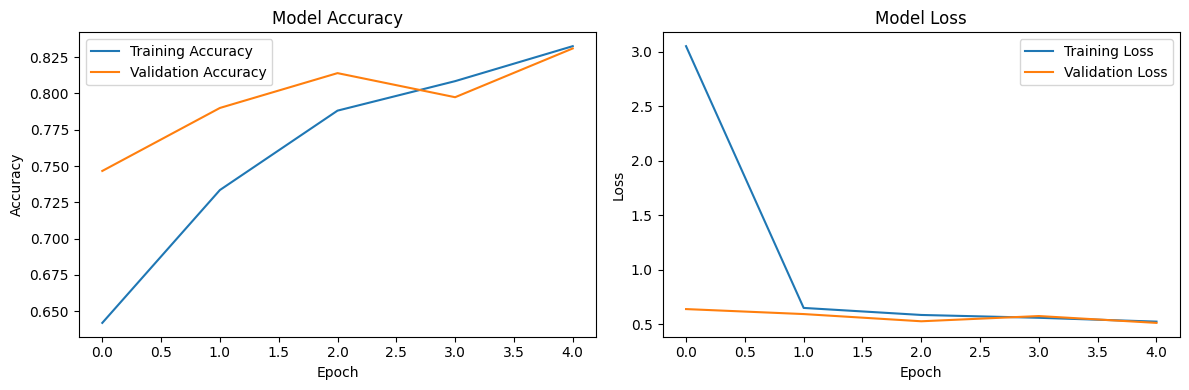

In [8]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

**Step 9: Save the Model and Tokenizer**

In [9]:
# Save the trained model
model.save('sentiment_analysis_lstm_model.h5')

# Save the tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!


**Step 10: Function for Predicting New Reviews**

In [10]:
def predict_sentiment(text, model, tokenizer, max_length=200):
    """
    Predict sentiment for a new review
    """
    # Clean the text
    cleaned_text = clean_text(text)

    # Convert to sequence and pad
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Make prediction
    prediction = model.predict(padded_sequence, verbose=0)[0][0]
    sentiment = 'positive' if prediction > 0.5 else 'negative'
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return sentiment, confidence, prediction

# Test the prediction function
sample_review = "This movie was absolutely fantastic! The acting was superb and the storyline was engaging."
sentiment, confidence, score = predict_sentiment(sample_review, model, tokenizer)
print(f"Review: {sample_review}")
print(f"Predicted sentiment: {sentiment}")
print(f"Confidence: {confidence:.4f}")
print(f"Raw score: {score:.4f}")

Review: This movie was absolutely fantastic! The acting was superb and the storyline was engaging.
Predicted sentiment: positive
Confidence: 0.8098
Raw score: 0.8098


**Function for Predicting New Reviews**

In [12]:
def predict_sentiment(text, model, tokenizer, max_length=500):
    """
    Predict sentiment for new text
    """
    # Clean the text
    cleaned_text = clean_text(text)

    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([cleaned_text])

    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Make prediction
    prediction = model.predict(padded_sequence)[0][0]

    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return sentiment, confidence, prediction

# Test the prediction function
test_reviews = [
    "This movie was absolutely fantastic! Great acting and storyline.",
    "Terrible movie, waste of time. Poor acting and boring plot.",
    "not bad"
]

print("\nTesting predictions:")
for review in test_reviews:
    sentiment, confidence, score = predict_sentiment(review, model, tokenizer, max_length)
    print(f"Review: {review[:50]}...")
    print(f"Predicted: {sentiment} (Confidence: {confidence:.4f}, Score: {score:.4f})")
    print("-" * 50)


Testing predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Review: This movie was absolutely fantastic! Great acting ...
Predicted: Positive (Confidence: 0.8059, Score: 0.8059)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Review: Terrible movie, waste of time. Poor acting and bor...
Predicted: Negative (Confidence: 0.9503, Score: 0.0497)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Review: not bad...
Predicted: Positive (Confidence: 0.6655, Score: 0.6655)
--------------------------------------------------
